<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт" data-toc-modified-id="Импорт-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Генерация-признаков-и-разбиение-на-выборки" data-toc-modified-id="Генерация-признаков-и-разбиение-на-выборки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Генерация признаков и разбиение на выборки</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Autoregression" data-toc-modified-id="Autoregression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Autoregression</a></span></li><li><span><a href="#Seasonal-Autoregressive-Integrated-Moving-Average" data-toc-modified-id="Seasonal-Autoregressive-Integrated-Moving-Average-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Seasonal Autoregressive Integrated Moving-Average</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Random Forest</a></span></li></ul></li><li><span><a href="#Анализ-остатков" data-toc-modified-id="Анализ-остатков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ остатков</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорт

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from random import random
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from pandas.plotting import lag_plot, autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX

import lightgbm as lgb
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

## Подготовка

Загружаем датасет, колонку с датами сразу используем как индексы.

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Изучим информацию о датасете.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Посмотрим, является ли индекс монотонным

In [6]:
data.index.is_monotonic

True

Итак, данные представляют собой количество вызовов такси каждые десять минут за полгода с марта по август включительно.

Сделаем ресемплирование по часу, при этом все заказы в час сложим.


In [7]:
data = data.resample('1H').sum()

## Анализ

Изучим график данных.

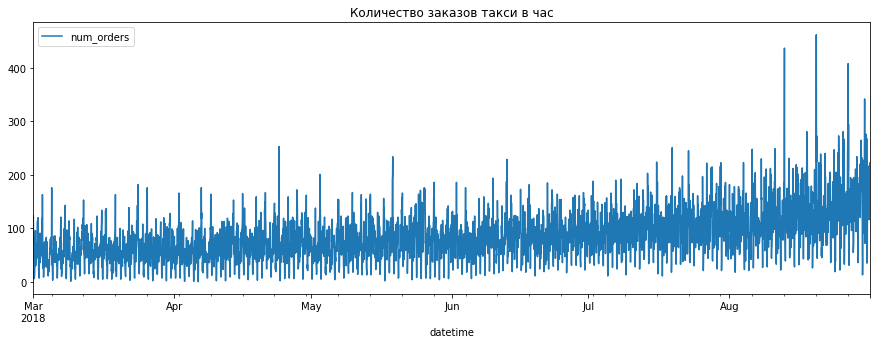

In [8]:
data.plot()
plt.title('Количество заказов такси в час')
plt.show()

Видим, что к сентябрю количество заказов немного растет. Также в течение месяца довольно сильные колебания.

Усредним данные с помощью скользящего среднего сначала и еще раз посмотрим графики.

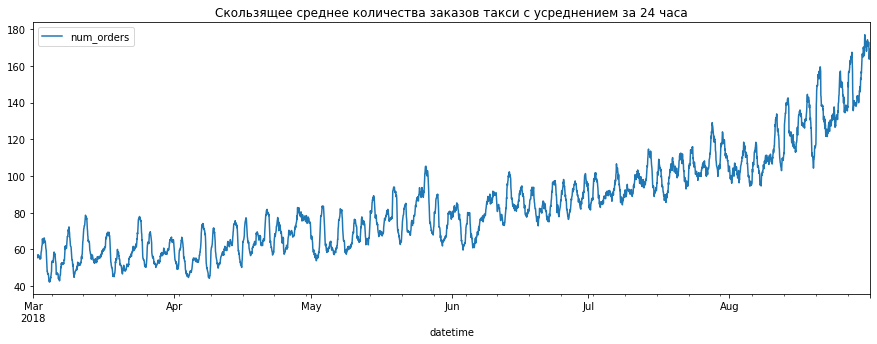

In [9]:
data.rolling(24).mean().plot()
plt.title('Скользящее среднее количества заказов такси с усреднением за 24 часа')
plt.show()

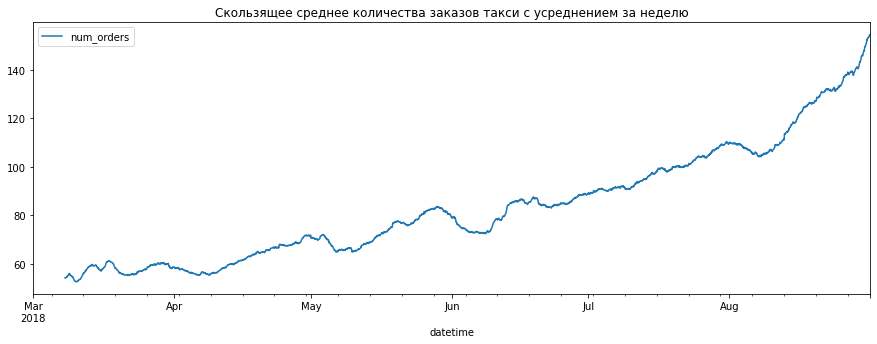

In [10]:
data.rolling(168).mean().plot()
plt.title('Скользящее среднее количества заказов такси с усреднением за неделю')
plt.show()

На первом графике видим, что колебания сохраняются при усреднении данных за сутки, то есть есть колебания изо дня в день. На втором при усреднении данных за неделю сильные колебания исчезают, но становится хорошо виден тренд - от марта к августу количество вызовов такси растет.

Посмотрим график отставания, который покажет существующие в данных паттерны.

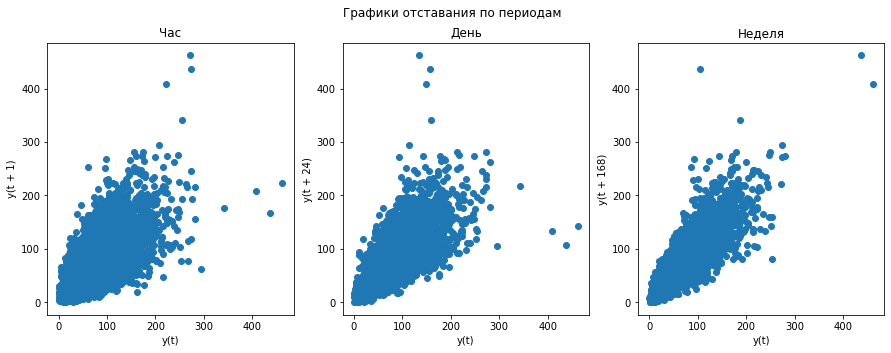

In [11]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
lag_plot(data, lag=1)
plt.title('Час')

plt.subplot(1, 3, 2)
lag_plot(data, lag=24)
plt.title('День')

plt.subplot(1, 3, 3)
lag_plot(data, lag=168)
plt.title('Неделя')

plt.suptitle('Графики отставания по периодам')
plt.show()

Для сравнения выведем также график отставания с произвольным периодом отставания.

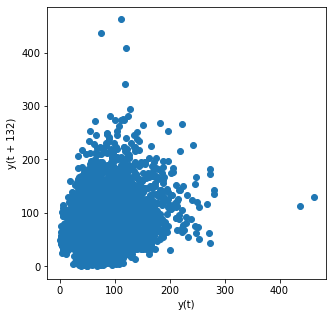

In [12]:
fig = plt.figure(figsize=(5, 5))
lag_plot(data, lag=132)
plt.show()

Мы видим, что на графиках в первом ряду автокорреляция по всем периодам гораздо больше, чем на последнем графике. Это значит, что есть корреляция между количеством вызовов в данный час и в предыдущий, сильнее корреляция между количеством вызовов в данный час дня и тот же час следующего дня и самая сильная - между количеством вызовов в данный час дня недели и тот же час того же дня следующей недели. Возможно это говорит о существовании соответствующей сезонности.

Выведем график автокорреляции.

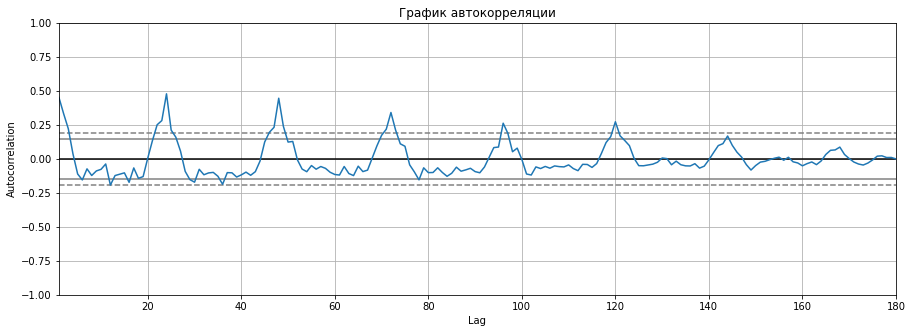

In [13]:
autocorrelation_plot(data[:180])
plt.title('График автокорреляции')
plt.show()

На графике видим пики в 24, 48, 72 часа и тд, с отставанием в сутки, то есть есть внутрисуточная сезонность.

Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

In [14]:
decomposed = seasonal_decompose(data)

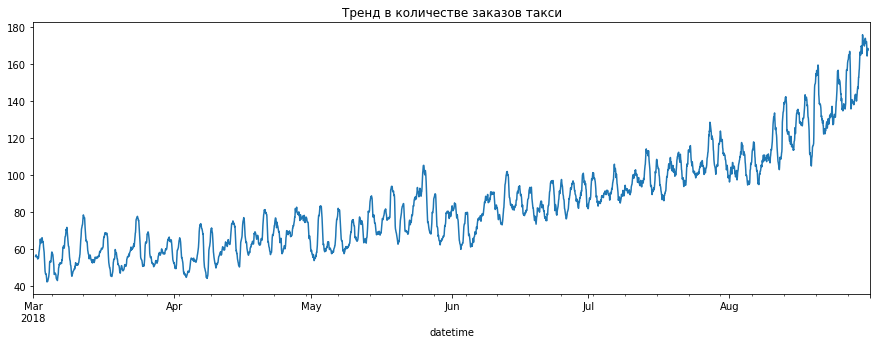

In [15]:
decomposed.trend.plot()
plt.title('Тренд в количестве заказов такси')
plt.show()

Похоже, что в данных есть тренд - увеличение количества заказов к сентябрю, но возможно это сезонные колебания в течение года, которые мы не можем оценить из-за взятого отрезка времени, всего полгода.

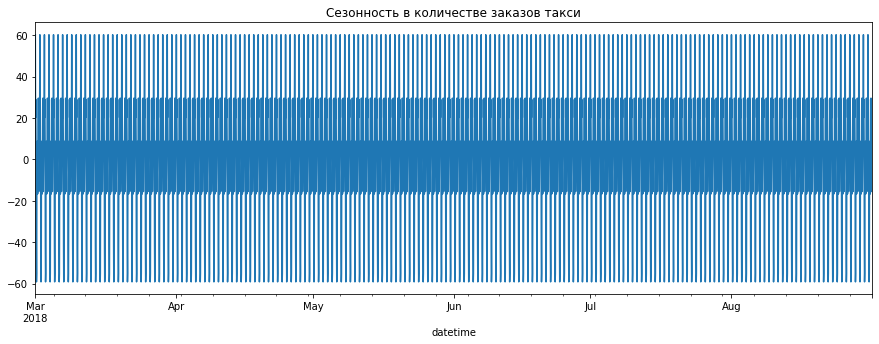

In [16]:
decomposed.seasonal.plot()
plt.title('Сезонность в количестве заказов такси')
plt.show()

Сезонность на очень маленьком отрезке времени, посмотрим это график на данных за одну неделю.

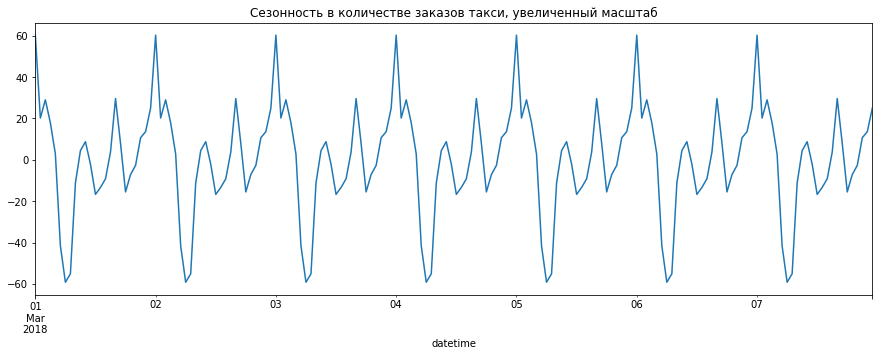

In [17]:
decomposed.seasonal[:168].plot()
plt.title('Сезонность в количестве заказов такси, увеличенный масштаб')
plt.show()

Здесь мы видим, что данные циклично повторяются в течение суток, есть внутрисуточная сезонность.

Попробуем увидеть дневную сезонность, для этого сделаем ресеплирование по дню и выведем сезонность найденную в этих данных.

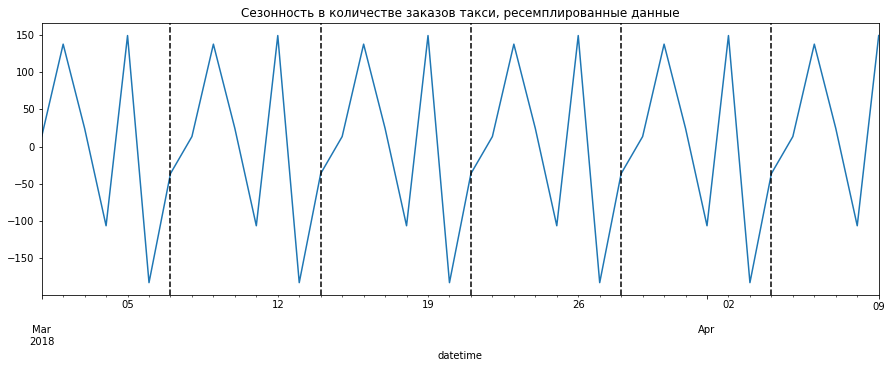

In [18]:
seasonal_decompose(data.resample('1D').sum()).seasonal[:40].plot()
plt.title('Сезонность в количестве заказов такси, ресемплированные данные')
xcoords = ['2018-03-07', '2018-03-14','2018-03-21', '2018-03-28', '2018-04-04']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
plt.show()

На графике мы видим, что на каждую неделю приходится по два пика, один в субботу и один в среду.

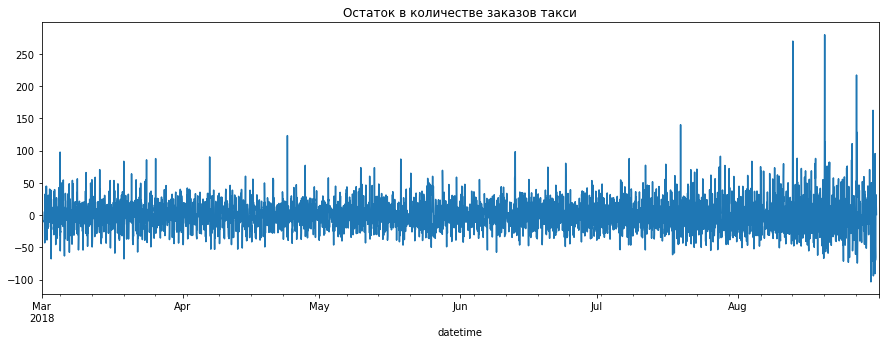

In [19]:
decomposed.resid.plot()
plt.title('Остаток в количестве заказов такси')
plt.show()

### Вывод

Данные представляют собой количество вызовов такси каждые час за полгода с марта по август включительно.
В данных есть тренд - количество заказов растет от марта к августу, хотя есть вероятность, что это сезонные колебания. Есть сезонность внутрисуточная и дневная. Также есть автокорреляция в данных, наиболее сильная также с задержкой в сутки.

## Генерация признаков и разбиение на выборки

Мы проанализировали исходные данные, теперь можно перейти к их подготовке.

In [20]:
#данные для авторегрессии
train, test = train_test_split(data, test_size=0.1, shuffle=False)
train, valid = train_test_split(train, test_size=0.111111, shuffle=False)

In [21]:
#данные для Prophetа
data_pr = data.reset_index()
data_pr.columns = ['ds', 'y']
train_pr, test_pr = train_test_split(data_pr, test_size=0.1, shuffle=False)
train_pr, valid_pr = train_test_split(train_pr, test_size=0.111111, shuffle=False)

In [22]:
#данные для LightGBM
data_add = data.copy()

In [23]:
data_add['dayofweek'] = data_add.index.dayofweek
data_add['hour'] = data_add.index.hour

In [24]:
data_add['seasonal'] = decomposed.seasonal
data_add['trend'] = decomposed.trend

In [25]:
data_add['seasonal_week'] = seasonal_decompose(data.resample('1D').sum()).seasonal
data_add['seasonal_week'] = data_add['seasonal_week'].fillna(method='pad')

data_add['trend_week'] = seasonal_decompose(data.resample('1D').sum()).trend
data_add['trend_week'] = data_add['trend_week'].fillna(method='pad')


In [26]:
data_add['rolling_mean_48'] = data_add['num_orders'].rolling(48).mean()
data_add['rolling_mean_24'] = data_add['num_orders'].rolling(24).mean()
data_add['rolling_mean_6'] = data_add['num_orders'].rolling(6).mean()

In [27]:
for i in range(1, 25):
    data_add['lag_' + str(i)] = data_add['num_orders'].shift(i)
data_add['lag_48'] = data_add['num_orders'].shift(48)
data_add['lag_week'] = data_add['num_orders'].shift(168)

In [28]:
data_add.head(3)

,num_orders,dayofweek,hour,seasonal,trend,seasonal_week,trend_week,rolling_mean_48,rolling_mean_24,rolling_mean_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_48,lag_week
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,60.248112,NaN,13.568634,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,20.177074,NaN,13.568634,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,28.982743,NaN,13.568634,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_add = data_add.dropna()

In [30]:
train_add, test_add = train_test_split(data_add, test_size=0.1, shuffle=False)
train_add, valid_add = train_test_split(train_add, test_size=0.111111, shuffle=False)

In [31]:
y_train = train_add['num_orders']
X_train = train_add.drop('num_orders', axis=1)

y_valid = valid_add['num_orders']
X_valid = valid_add.drop('num_orders', axis=1)

y_test = test_add['num_orders']
X_test = test_add.drop('num_orders', axis=1)

## Обучение

Обучим несколько моделей, три модели для предсказания временных рядов на исходном датасете:
* Autoregression
* SARIMA
* Prophet

И три обычные модели на датасете с дополнительно сгенерированными признаками:
* LightGBM
* Decision Tree
* Random Forest

In [32]:
results = []

Создадим функцию для вывода графиков предсказанного ряда и настоящего.

In [33]:
def plot_pred_time_series(predictions, answer):
    plt.plot(answer)
    plt.plot(predictions, color='red')
    plt.show()

### Autoregression

In [34]:
ar = AutoReg(train, lags=120)
ar = ar.fit()
predictions = ar.predict(start=len(train), end=len(train)+len(valid)-1, dynamic=False)
rmse = sqrt(mean_squared_error(valid, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 34.654


/home/alena/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


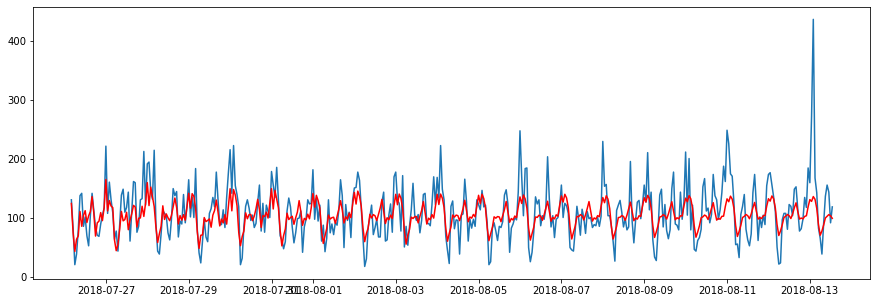

In [35]:
plot_pred_time_series(predictions, valid)

Теперь сделаем так, чтобы авторегрессия учитывала свои собственные предсказания для последующих предсказаний.

In [36]:
window = 120
model = AutoReg(train, lags=120)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = np.array(train[len(train)-window:])
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(valid)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = np.array(valid)[t]
    predictions.append(yhat)
    history.append(obs)
rmse = sqrt(mean_squared_error(valid, predictions))
print('Test RMSE: %.3f' % rmse)

/home/alena/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Test RMSE: 29.404


In [37]:
results.append(rmse)

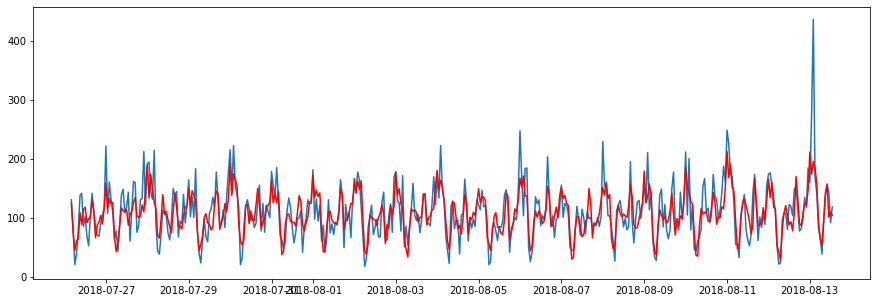

In [38]:
predictions = pd.Series(predictions, index=valid.index)
plot_pred_time_series(predictions, valid)

### Seasonal Autoregressive Integrated Moving-Average

In [39]:
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24), trend='n', random_state=42)
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59702D+00    |proj g|=  7.51180D-02


 This problem is unconstrained.



At iterate    5    f=  4.52767D+00    |proj g|=  1.65851D-02

At iterate   10    f=  4.47279D+00    |proj g|=  1.15702D-01

At iterate   15    f=  4.43891D+00    |proj g|=  4.35377D-03

At iterate   20    f=  4.43670D+00    |proj g|=  3.28356D-02

At iterate   25    f=  4.43454D+00    |proj g|=  1.44156D-02

At iterate   30    f=  4.43436D+00    |proj g|=  1.05345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   2.223D-06   4.434D+00
  F =   4.4343622822102660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [40]:
yhat = model_fit.forecast(len(valid))
rmse = sqrt(mean_squared_error(valid, yhat))
rmse

31.488860035692277

In [41]:
results.append(rmse)

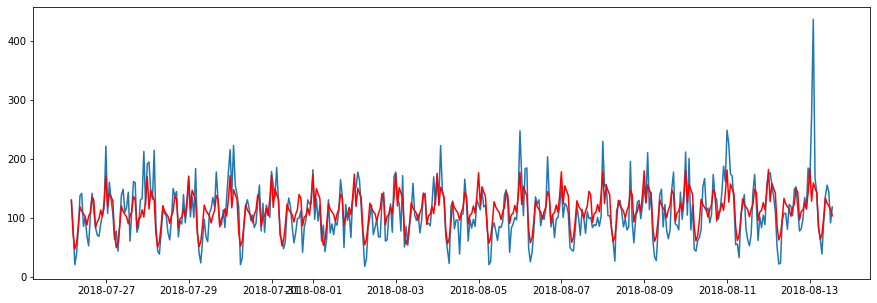

In [42]:
predictions = pd.Series(yhat, index=valid.index)
plot_pred_time_series(predictions, valid)

### Prophet

In [43]:
m = Prophet()
m.fit(train_pr)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -127.407


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       6657.17   0.000238575       120.566   7.993e-07       0.001      169  LS failed, Hessian reset 
      99       6657.23   0.000107324       65.9133      0.8714      0.8714      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       6657.33   6.07541e-05       66.3109   8.592e-07       0.001      298  LS failed, Hessian reset 
     199       6657.39   4.67578e-07       76.0934     0.09354     0.09354      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       6657.39   4.59977e-07       68.5835      0.2649        0.84      363   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [44]:
future = m.make_future_dataframe(periods=len(valid_pr), freq='H', include_history=False)
future.head()

,ds
0,2018-07-26 04:00:00
1,2018-07-26 05:00:00
2,2018-07-26 06:00:00
3,2018-07-26 07:00:00
4,2018-07-26 08:00:00


In [45]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2018-07-26 04:00:00,93.112714,62.221397,121.670595
1,2018-07-26 05:00:00,66.750993,36.491766,96.661015
2,2018-07-26 06:00:00,53.321316,22.955682,81.162343
3,2018-07-26 07:00:00,61.370768,30.930258,90.946865
4,2018-07-26 08:00:00,84.803393,53.826769,114.062520


In [46]:
pred = forecast['yhat'].astype('int')

In [47]:
rmse = sqrt(mean_squared_error(valid_pr['y'].values, pred))
rmse

33.75607872189442

In [48]:
results.append(rmse)

In [49]:
answers = valid_pr.set_index('ds')
predictions = pd.Series(pred.values, index=answers.index)

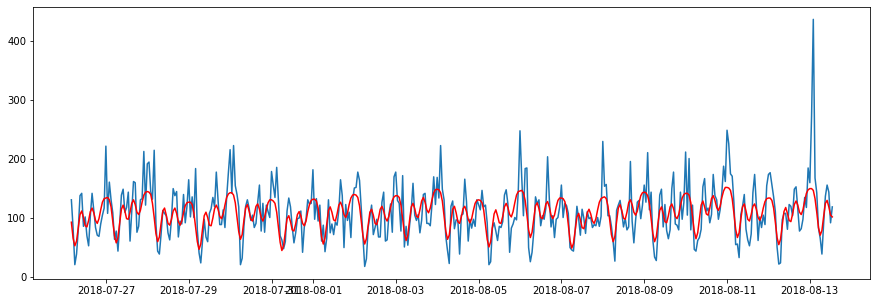

In [50]:
plot_pred_time_series(predictions, answers)

### LightGBM

In [51]:
lgbr = lgb.LGBMRegressor()
lgb_params = {
    'boosting_type' : ['dart', 'gbdt', 'goss'],
    'max_depth': [15, 30, 45],
    'num_leaves': [100, 200]
}
cv = TimeSeriesSplit(n_splits=8)
lgb_gs = GridSearchCV(lgbr, lgb_params,scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

In [52]:
lgb_gs.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['dart', 'gbdt', 'goss'],
                         'max_depth': [15, 30, 45], 'num_leaves': [100, 200]},
             scoring='neg_mean_squared_error')

In [53]:
lgb_gs.best_estimator_

LGBMRegressor(max_depth=30, num_leaves=100)

In [55]:
lgb_gs.best_estimator_.fit(X_train, y_train)

LGBMRegressor(max_depth=30, num_leaves=100)

In [56]:
pred_lgb = lgb_gs.best_estimator_.predict(X_valid)
rmse = sqrt(mean_squared_error(y_valid, pred_lgb))
rmse

25.718377859133167

In [57]:
results.append(rmse)

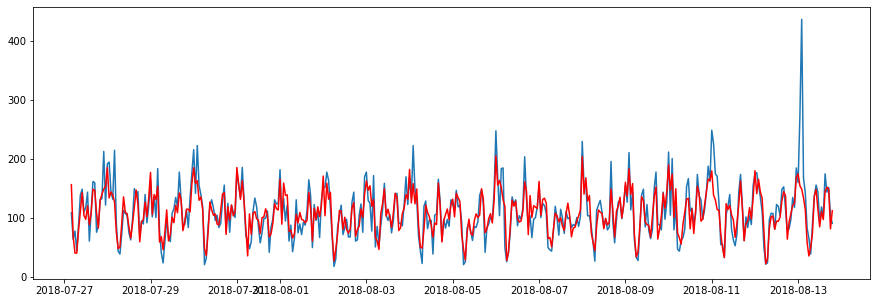

In [58]:
pred_lgb = pd.Series(pred_lgb, index=y_valid.index)
plot_pred_time_series(pred_lgb, y_valid)

### Decision Tree

In [59]:
grid={"max_depth":range(1, 20), "min_samples_split":range(2, 10)}
cv = TimeSeriesSplit(n_splits=8)
destree = DecisionTreeRegressor(random_state=42)
destree_cv=GridSearchCV(destree, grid, cv=cv, scoring = 'neg_mean_squared_error')
destree_cv.fit(X_train, y_train)

print("tuned hyperparameters :(best parameters) ",destree_cv.best_params_)
print("RMSE:",destree_cv.best_score_)

tuned hyperparameters :(best parameters)  {'max_depth': 5, 'min_samples_split': 2}
RMSE: -518.6050032052494


In [60]:
destree_cv.best_estimator_.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [61]:
pred = destree_cv.best_estimator_.predict(X_valid)

In [62]:
rmse = sqrt(mean_squared_error(y_valid, pred))
rmse

31.487852930358056

In [63]:
results.append(rmse)

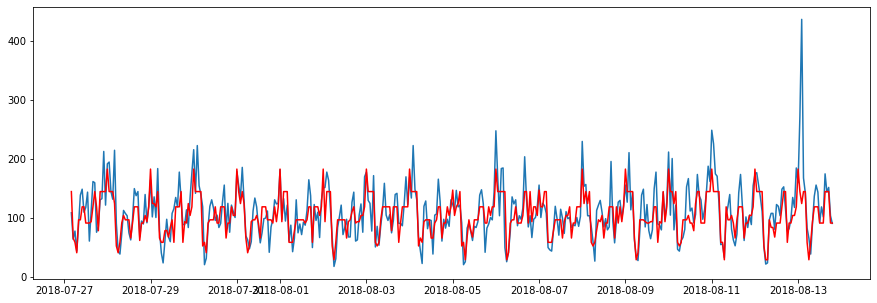

In [64]:
pred = pd.Series(pred, index=y_valid.index)
plot_pred_time_series(pred, y_valid)

### Random Forest

In [65]:
rfor = RandomForestRegressor(random_state=42, max_depth=8, min_samples_split=5)

In [66]:
grid={"n_estimators": range(1, 301, 50)}
cv = TimeSeriesSplit(n_splits=8)
rfor_cv=GridSearchCV(rfor, grid, cv=cv, scoring = 'neg_mean_squared_error')
rfor_cv.fit(X_train, y_train)

print("tuned hyperparameters :(best parameters) ",rfor_cv.best_params_)
print("RMSE:",rfor_cv.best_score_)

tuned hyperparameters :(best parameters)  {'n_estimators': 251}
RMSE: -375.1783091489575


In [67]:
rfor_cv.best_estimator_.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=5, n_estimators=251,
                      random_state=42)

In [68]:
pred = rfor_cv.best_estimator_.predict(X_valid)

In [69]:
rmse = sqrt(mean_squared_error(y_valid, pred))
rmse

27.64640110866571

In [70]:
results.append(rmse)

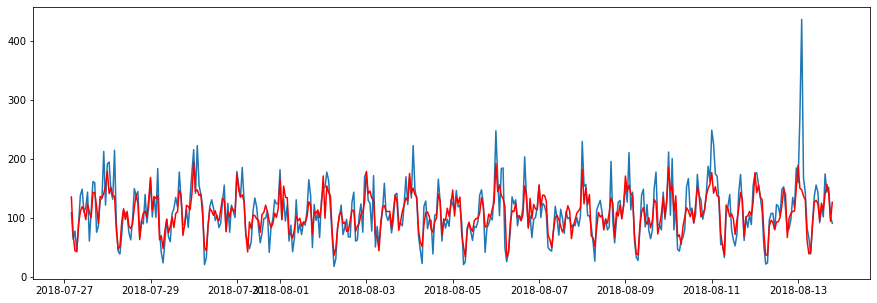

In [71]:
pred = pd.Series(pred, index=y_valid.index)
plot_pred_time_series(pred, y_valid)

## Анализ остатков

Выведем таблицу результатов и сравним все модели.

In [72]:
res_df = pd.DataFrame(results, index=('AR', 'SARIMA', 'Prophet', 'LightGBM', 'Decision Tree', 'Random Forest'))

In [73]:
res_df

,0
AR,29.403565
SARIMA,31.488860
Prophet,33.756079
LightGBM,25.718378
Decision Tree,31.487853
Random Forest,27.646401


Лучшее качество показала модель LightGBM. Проведем анализ остатков и посмотрим, как можно улучшить модель.

In [74]:
residuals = y_valid - pred_lgb

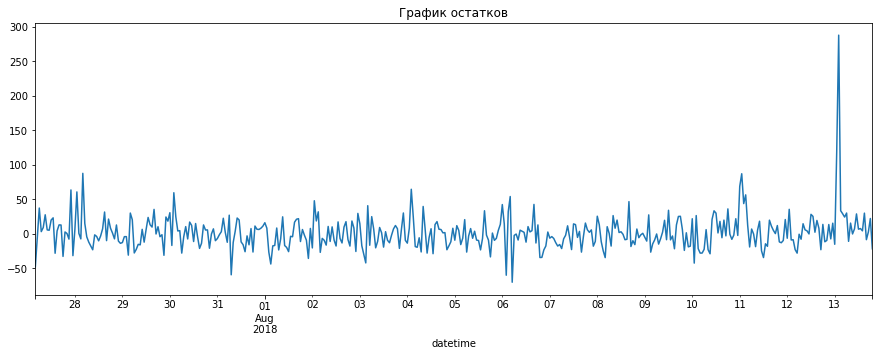

In [75]:
residuals.plot()
plt.title('График остатков')
plt.show()

In [76]:
residuals.describe()

count    424.000000
mean       1.818419
std       25.684318
min      -69.996397
25%      -12.179476
50%       -0.091602
75%       12.944657
max      287.822903
dtype: float64

Мы видим, что среднее не равно нулю, а это значит, что прибавив смещение к предсказаниям модели, мы сможем добиться лучшего качества.

/home/alena/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


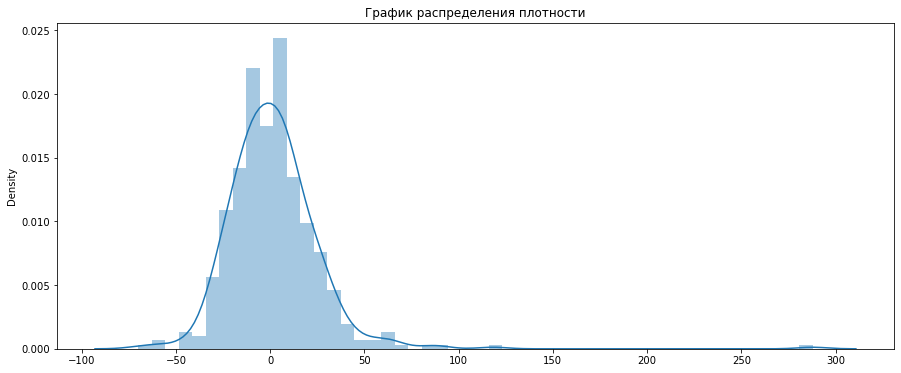

In [77]:
plt.figure(figsize=(15,6))
plot = sns.distplot(residuals,bins=50, kde=True)
plt.title('График распределения плотности')
plt.show()

На графике мы не видим смещения и в целом распределение похоже на нормальное. Значит модель предсказывает достаточно адекватно.

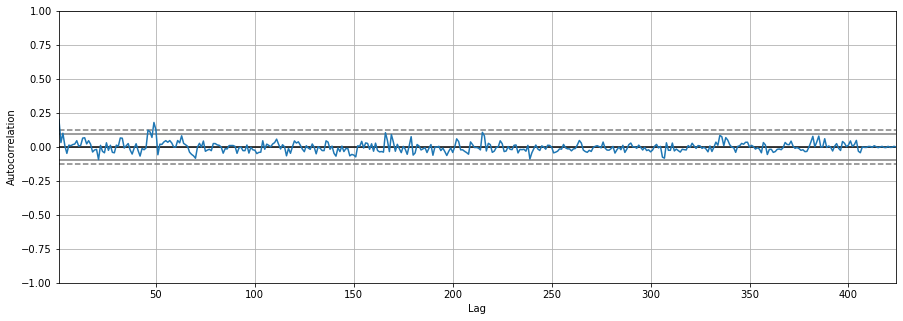

In [78]:
autocorrelation_plot(residuals)
plt.show()

Значимая автокорреляция есть на отметке около 48 часов. Возможно это связанно с какими-то внешними факторами, так как при обучении модели данные за два дня до были учтены как один из сгенерированных признаков.

## Тестирование

Переобучим ее на данных из трейна и валидирующей выборки и проверим на тесте.

In [79]:
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

In [80]:
lgb_gs.best_estimator_.fit(X, y)

LGBMRegressor(max_depth=30, num_leaves=100)

In [81]:
pred = lgb_gs.best_estimator_.predict(X_test)

In [82]:
rmse = sqrt(mean_squared_error(y_test, pred))
rmse

34.43280536085263

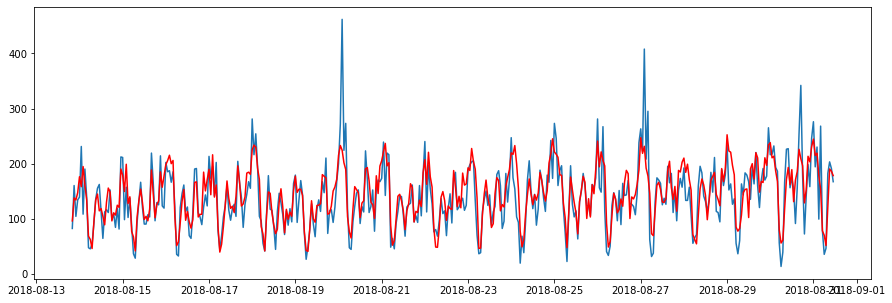

In [83]:
pred = pd.Series(pred, index=y_test.index)
plt.plot(y_test)
plt.plot(pred, color='red')
plt.show()